In [1]:
import json
from datetime import datetime, timedelta
from pprint import pprint
import os
import pickle

import requests
from dotenv import load_dotenv, find_dotenv
import geopandas as gpd
import folium
from shapely.geometry import mapping
import pytz
from tqdm.auto import tqdm, trange

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
google_maps_api_key = os.environ["GOOGLE_MAPS_API_KEY"]
mt_token = os.environ["MOBILITY_TWIN_TOKEN"]
mt_auth = f"Bearer {mt_token}"

In [4]:
def plot_map(gdf):
    # Initialize a Folium map
    m = folium.Map(
        location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],
        zoom_start=10,
    )

    # Add the shapefile to the map
    for i, row in gdf.iterrows():
        geom = mapping(row["geometry"])
        color = row["color"]
        folium.GeoJson(
            geom, style_function=lambda x, color=color: {"color": color}
        ).add_to(m)
    return m

## Google Maps Routes API

In [47]:
session = requests.Session()
headers = {
    "Content-Type": "application/json",
    "X-Goog-Api-Key": google_maps_api_key,
    "X-Goog-FieldMask": "*" # "routes.legs.distanceMeters,routes.legs.duration",
}
session.headers.update(headers)

In [6]:
# Function to get the RFC 3339 formatted time for a given timezone
def get_rfc3339_time(
    hours_from_now=0, minutes_from_now=0, timezone_str="Europe/Brussels"
):
    tz = pytz.timezone(timezone_str)
    future_time = datetime.now(tz) + timedelta(
        hours=hours_from_now, minutes=minutes_from_now
    )
    return future_time.isoformat()

In [18]:
gdf_full = gpd.read_file("../data/segments.geojson", driver="GeoJSON")
gdf = gdf_full[["line_id", "direction", "geometry"]]
gdf["line_id"] = gdf["line_id"].astype(int)
gdf.head()

/Users/cookiefinder/miniconda3/envs/libcity/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,line_id,direction,geometry
0,12,1,"LINESTRING (4.36479 50.84185, 4.36479 50.84185..."
1,12,1,"LINESTRING (4.36712 50.84033, 4.36713 50.84032..."
2,12,1,"LINESTRING (4.37362 50.83978, 4.37396 50.84038..."
3,12,1,"LINESTRING (4.38391 50.84347, 4.38391 50.84347..."
4,12,1,"LINESTRING (4.39787 50.85398, 4.39803 50.85436..."


In [9]:
def get_locations_data(gdf):
    locations = []
    # obtain coordinates for each stop in the line
    for _, row in gdf.iterrows():
        coords = row.geometry.coords[0]
        lon, lat = coords
        location_obj = {"location": {"latLng": {"latitude": lat, "longitude": lon}}}
        locations.append(location_obj)

    # the final coords are the last point in the last stop
    final_coords = row.geometry.coords[-1]
    lon, lat = final_coords
    location_obj = {"location": {"latLng": {"latitude": lat, "longitude": lon}}}
    locations.append(location_obj)

    return locations

In [10]:
def get_speed_data_routes_api(gdf, time):
    url = "https://routes.googleapis.com/directions/v2:computeRoutes"
    locations = get_locations_data(gdf)
    total_data = []

    for i in range(0, len(locations), 25):
        if i == 0:
            locations_list = locations[i : i + 25]
        else:
            locations_list = locations[i - 1 : i + 25]

        payload = {
            "origin": locations_list[0],
            "destination": locations_list[-1],
            "intermediates": locations_list[1:-1],
            "routingPreference": "TRAFFIC_AWARE_OPTIMAL",
            "computeAlternativeRoutes": False,
            "routeModifiers": {
                "avoidTolls": False,
                "avoidHighways": False,
                "avoidFerries": False,
            },
            "departureTime": time,
            "languageCode": "en-US",
            "units": "METRIC",
        }

        response = session.post(url, data=json.dumps(payload))

        # Check the response
        if response.status_code == 200:
            data = response.json()
            if len(locations_list) > 1:
                assert len(data["routes"][0]["legs"]) + 1 == len(
                    locations_list
                ), f"A route was skipped ({len(data['routes'][0]['legs']) + 1} != {len(locations_list)})"
            data = data["routes"][0]["legs"]
            total_data.extend(data)
        else:
            pprint(response.json())
            raise Exception(f"Request failed with status code: {response.status_code}")
    return total_data

In [11]:
def collect_google_maps_data(gdf, H=8, interval=10, debug=False):
    grouped = gdf.groupby(["line_id", "direction"])

    if os.path.isfile("../data/gm_segment_speeds.pkl"):
        with open("../data/gm_segment_speeds.pkl", "rb") as f:
            segment_speeds = pickle.load(f)
    else:
        segment_speeds = {}

    # 2. Iterate over each group
    for hour in trange(H):
        for minute in range(0, 60, interval):
            for (line_id, direction), group in grouped:
                # only future data allowed
                if hour == 0 and minute == 0:
                    minute += 1
                # do not recollect data for segments
                if (line_id, direction, hour, minute) in segment_speeds:
                    continue
                # convert current datetime to iso format
                time = get_rfc3339_time(hours_from_now=hour, minutes_from_now=minute)
                speed_data = get_speed_data_routes_api(group, time)
                if speed_data is None:
                    raise Exception("Stopped due to error")
                else:
                    for i, estimates in enumerate(speed_data):
                        duration = int(estimates["duration"][:-1])
                        if duration == 0:
                            speed_data[i]["distanceMeters"] = 0
                            speed_data[i]["speed"] = 0
                        else:
                            speed_data[i]["speed"] = (
                                estimates["distanceMeters"] / duration
                            )
                    segment_speeds[(line_id, direction, hour, minute)] = {
                        "time": time,
                        "speed_data": speed_data,
                    }
                    if debug:
                        print(
                            f"Processed segment for line_id: {line_id}, direction: {direction}, hours: {hour}, minutes: {minute}"
                        )
    else:
        for (line_id, direction), group in grouped:
            # finished successfully, so get data for last hour
            time = get_rfc3339_time(hours_from_now=H)
            speed_data = get_speed_data_routes_api(group, time)
            if speed_data is None:
                raise Exception("Stopped due to error")
            else:
                for i, estimates in enumerate(speed_data):
                    duration = int(estimates["duration"][:-1])
                    if duration == 0:
                        speed_data[i]["distanceMeters"] = 0
                        speed_data[i]["speed"] = 0
                    else:
                        speed_data[i]["speed"] = estimates["distanceMeters"] / duration
                segment_speeds[(line_id, direction, H, 0)] = {
                    "time": time,
                    "speed_data": speed_data,
                }
                if debug:
                    print(
                        f"Processed segment for line_id: {line_id}, direction: {direction}, hours: {H}, minutes: 0"
                    )

    with open("../data/gm_segment_speeds.pkl", "wb") as f:
        pickle.dump(segment_speeds, f)

    return segment_speeds

In [30]:
H = 7
interval = 10
segment_speeds = collect_google_maps_data(gdf, H=H, interval=interval)

  0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
stops = gpd.read_file("../preprocessed_data/Stops.geojson", driver="GeoJSON")
stops

,stop_id,direction,stop_name,stop_sequence,line_id,geometry
0,1780,0,TRONE,0,12,POINT (50.84185 4.36484)
1,6433,0,TRONE,1,12,POINT (50.84030 4.36712)
2,1131,0,LUXEMBOURG,2,12,POINT (50.83975 4.37368)
3,1418,0,SCHUMAN,3,12,POINT (50.84347 4.38398)
4,2247,0,MEISER,4,12,POINT (50.85398 4.39789)
...,...,...,...,...,...,...
2184,1453,1,CALYPSO 2000,22,95,POINT (50.80301 4.40978)
2185,4313,1,LES 3 TILLEULS,23,95,POINT (50.80258 4.41250)
2186,4314,1,CERISAIE,24,95,POINT (50.80262 4.41877)
2187,4315,1,FAUCONNERIE,25,95,POINT (50.80136 4.42239)


In [31]:
gdf_full

,id,end,color,start,line_id,distance,direction,geometry
0,1780,6433,#4C8B33,1780,12,0.000000,1,"LINESTRING (4.36479 50.84185, 4.36479 50.84185..."
1,6433,1131,#4C8B33,6433,12,688.862247,1,"LINESTRING (4.36712 50.84033, 4.36713 50.84032..."
2,1131,1418,#4C8B33,1131,12,1734.101558,1,"LINESTRING (4.37362 50.83978, 4.37396 50.84038..."
3,1418,2247,#4C8B33,1418,12,3922.269263,1,"LINESTRING (4.38391 50.84347, 4.38391 50.84347..."
4,2247,4556,#4C8B33,2247,12,6843.167479,1,"LINESTRING (4.39787 50.85398, 4.39803 50.85436..."
...,...,...,...,...,...,...,...,...
2056,4311,1453,#306196,4311,95,14014.553861,2,"LINESTRING (4.40673 50.80521, 4.40673 50.80521..."
2057,1453,4313,#306196,1453,95,14626.488319,2,"LINESTRING (4.40978 50.80304, 4.40978 50.80304..."
2058,4313,4314,#306196,4313,95,15031.512884,2,"LINESTRING (4.41250 50.80259, 4.41250 50.80259..."
2059,4314,4315,#306196,4314,95,15996.461667,2,"LINESTRING (4.41878 50.80263, 4.41878 50.80263..."


In [39]:
gdf_full_copy = gdf_full.copy()
gdf_full_copy["direction"] -= 1
gdf_full_copy["line_id"] = gdf_full_copy["line_id"].astype(int)
gdf_with_names = gdf_full_copy.merge(
    stops[["stop_id", "stop_name", "line_id", "direction"]],
    left_on=["start", "line_id", "direction"],
    right_on=["stop_id", "line_id", "direction"],
).drop(columns=["stop_id"])
gdf_with_names = gdf_with_names.merge(
    stops[["stop_id", "stop_name", "line_id", "direction"]],
    left_on=["end", "line_id", "direction"],
    right_on=["stop_id", "line_id", "direction"],
).drop(columns=["stop_id"])
gdf_with_names.head()

,id,end,color,start,line_id,distance,direction,geometry,stop_name_x,stop_name_y
0,1780,6433,#4C8B33,1780,12,0.000000,0,"LINESTRING (4.36479 50.84185, 4.36479 50.84185...",TRONE,TRONE
1,6433,1131,#4C8B33,6433,12,688.862247,0,"LINESTRING (4.36712 50.84033, 4.36713 50.84032...",TRONE,LUXEMBOURG
2,1131,1418,#4C8B33,1131,12,1734.101558,0,"LINESTRING (4.37362 50.83978, 4.37396 50.84038...",LUXEMBOURG,SCHUMAN
3,1418,2247,#4C8B33,1418,12,3922.269263,0,"LINESTRING (4.38391 50.84347, 4.38391 50.84347...",SCHUMAN,MEISER
4,2247,4556,#4C8B33,2247,12,6843.167479,0,"LINESTRING (4.39787 50.85398, 4.39803 50.85436...",MEISER,GENEVE


In [45]:
grouped = gdf_with_names.groupby(["line_id", "direction"])
groups = grouped.groups
req_group = gdf_with_names.loc[groups[(71, 0)]]
req_group

,id,end,color,start,line_id,distance,direction,geometry,stop_name_x,stop_name_y
1458,3521,3556,#4C8B33,3521,71,0.000000,0,"LINESTRING (4.40749 50.81596, 4.40749 50.81596...",BEAULIEU,DELTA
1459,3556,1598,#4C8B33,3556,71,582.071087,0,"LINESTRING (4.40428 50.81822, 4.40427 50.81822...",DELTA,CHIREC
1460,1598,3557,#4C8B33,1598,71,1300.493677,0,"LINESTRING (4.39979 50.81707, 4.39978 50.81707...",CHIREC,FRAITEUR
1461,3557,3558,#4C8B33,3557,71,1862.124868,0,"LINESTRING (4.39610 50.81786, 4.39610 50.81787...",FRAITEUR,CIM. D'IXELLES
1462,3558,3559,#4C8B33,3558,71,2728.141036,0,"LINESTRING (4.39061 50.81598, 4.39014 50.81582...",CIM. D'IXELLES,ULB
1463,3559,3525,#4C8B33,3559,71,3695.333999,0,"LINESTRING (4.38446 50.81388, 4.38438 50.81387...",ULB,JEANNE
1464,3525,2351,#4C8B33,3525,71,3939.925988,0,"LINESTRING (4.38369 50.81525, 4.38368 50.81526...",JEANNE,BUYL
1465,2351,3562,#4C8B33,2351,71,4843.123054,0,"LINESTRING (4.37878 50.81890, 4.37842 50.81923...",BUYL,GEO BERNIER
1466,3562,3570,#4C8B33,3562,71,5272.275025,0,"LINESTRING (4.37659 50.82083, 4.37658 50.82084...",GEO BERNIER,ETANGS D'IXELLES
1467,3570,3572,#4C8B33,3570,71,5843.181478,0,"LINESTRING (4.37396 50.82369, 4.37384 50.82379...",ETANGS D'IXELLES,FLAGEY


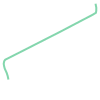

In [48]:
req_row = req_group.loc[1472]
req_row.geometry

In [49]:
coords_lst = req_row.geometry.coords
coords_lst[0]

(4.3619819167645115, 50.83815232161101)

In [55]:
coords_lst = req_row.geometry.coords

payload = {
    "origin": {"location": {"latLng": {"latitude": coords_lst[0][1], "longitude": coords_lst[0][0]}}},
    "destination": {"location": {"latLng": {"latitude": coords_lst[-1][1], "longitude": coords_lst[-1][0]}}},
    "routingPreference": "TRAFFIC_AWARE_OPTIMAL",
    # "travelMode": "TRANSIT",
    "computeAlternativeRoutes": False,
    "routeModifiers": {
        "avoidTolls": False,
        "avoidHighways": False,
        "avoidFerries": False,
    },
    "languageCode": "en-US",
    "units": "METRIC",
}
url = "https://routes.googleapis.com/directions/v2:computeRoutes"
response = session.post(url, data=json.dumps(payload))

In [56]:
response.json()

{'routes': [{'legs': [{'distanceMeters': 519,
     'duration': '167s',
     'staticDuration': '147s',
     'polyline': {'encodedPolyline': 'mihuHg}rYI@K@QBU?OC?QCKKMC?QDIR?B@V@FSNkAdBQc@yDeJO[GOy@mBIUEOaAaCt@C'},
     'startLocation': {'latLng': {'latitude': 50.8381508,
       'longitude': 4.3619572}},
     'endLocation': {'latLng': {'latitude': 50.8408088,
       'longitude': 4.364863199999999}},
     'steps': [{'distanceMeters': 43,
       'staticDuration': '16s',
       'polyline': {'encodedPolyline': 'mihuHg}rYI@K@QBU?OC'},
       'startLocation': {'latLng': {'latitude': 50.8381508,
         'longitude': 4.3619572}},
       'endLocation': {'latLng': {'latitude': 50.838535,
         'longitude': 4.3619449999999995}},
       'navigationInstruction': {'maneuver': 'DEPART',
        'instructions': "Head north on Chau. d'Ixelles/Elsensesteenweg/N247 toward Bolwerksquare/Sq. du Bastion"},
       'localizedValues': {'distance': {'text': '43 m'},
        'staticDuration': {'text': '1 min'}